In [1]:
# Case II
# Read data into bicup dataframe
# setwd("C:/Users/graeme/Documents/OMIS 3000 - R/csv Files/dmba")   # Adapt this to point to your data diectory
bicup.df <- read.csv("bicup2006.csv") # Read in data
head(bicup.df)  # Examine first few rows of bicup.df

DATE,TIME,DEMAND
<fct>,<fct>,<int>
1-Mar-05,6:30,1
1-Mar-05,6:45,2
1-Mar-05,7:00,4
1-Mar-05,7:15,0
1-Mar-05,7:30,10
1-Mar-05,7:45,13


In [21]:
# These are installed by default using the install.R file in the root of the project
# install.packages("forecast")
# install.packages("tseries")
# install.packages("prophet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dygraphs’, ‘extraDistr’




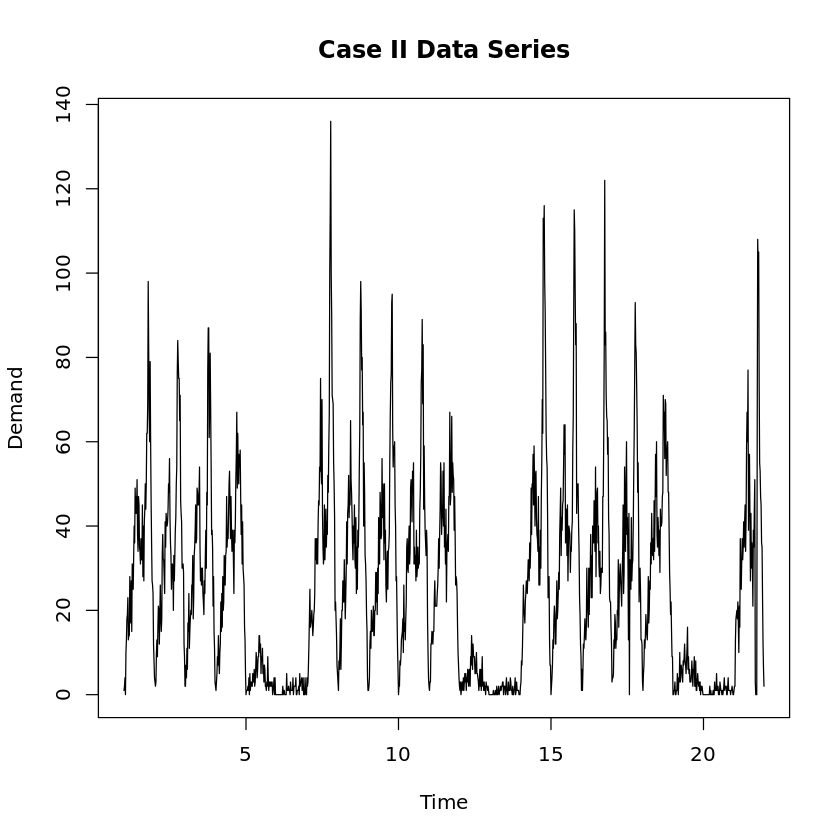

In [6]:
# Create time series representation of data
# Note that the data features 21 da
library(forecast)
bicup.ts <- ts(bicup.df$DEMAND, start = c(1, 1), end = c(21, 63), freq = 63)
plot(bicup.ts, xlab = "Time", ylab = "Demand",main="Case II Data Series")

In [7]:
# Partition the time series
train.ts <- window(bicup.ts, start = c(1, 1), end = c(18, 63))   #18 days for training
valid.ts <- window(bicup.ts, start = c(19,1 ), end = c(21, 63))  #3 days for validation
# Using 14 days for training and 7 for validation may be an idea...

In [8]:
# We need a day indicator - generate day dummies
days <- rep(rep(c(1:7), each = 63), 4)  
bicup.df$day <- days[1:dim(bicup.df)[1]] # Inserts days in bicup.df
bicup.df$day <- as.factor(bicup.df$day) # Makes sure that R treats days as a factor (i.e., categorical) variable
# Partition the bicup data frame
train.df <- bicup.df[1:(18*63),]              # Again, 18 days of training data
valid.df <- bicup.df[(18*63+1):(21*63),]      # 3 days of validation data
next3days.df <- bicup.df[(21*63+1):(24*63),]  # And we'll predict three days beyond that

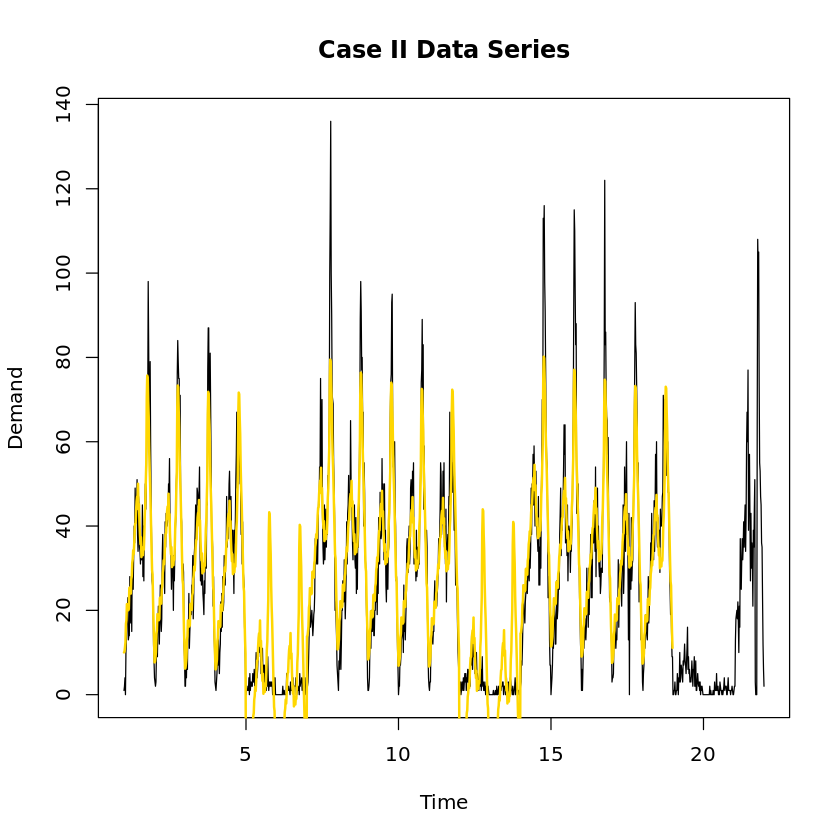

In [10]:
# MODEL #1 MODEL WITH TREND & SEASONALITY (Section 17.3 in Shmueli)
# Some tuning options: quadratic and exponential trend
# Season refers to time-of-day effects in htis data
bicup.lm <- tslm(train.ts ~ trend + season + day, data = train.df)   # Build trend & seasonal model
plot(bicup.ts, xlab = "Time", ylab = "Demand",main="Case II Data Series")
lines(bicup.lm$fitted, lwd = 2, col = "gold")    # Plot predictions for training data in gold

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,2.761069,16.32306,11.38113,33.63075,95.31534,0.8168443,1.302857


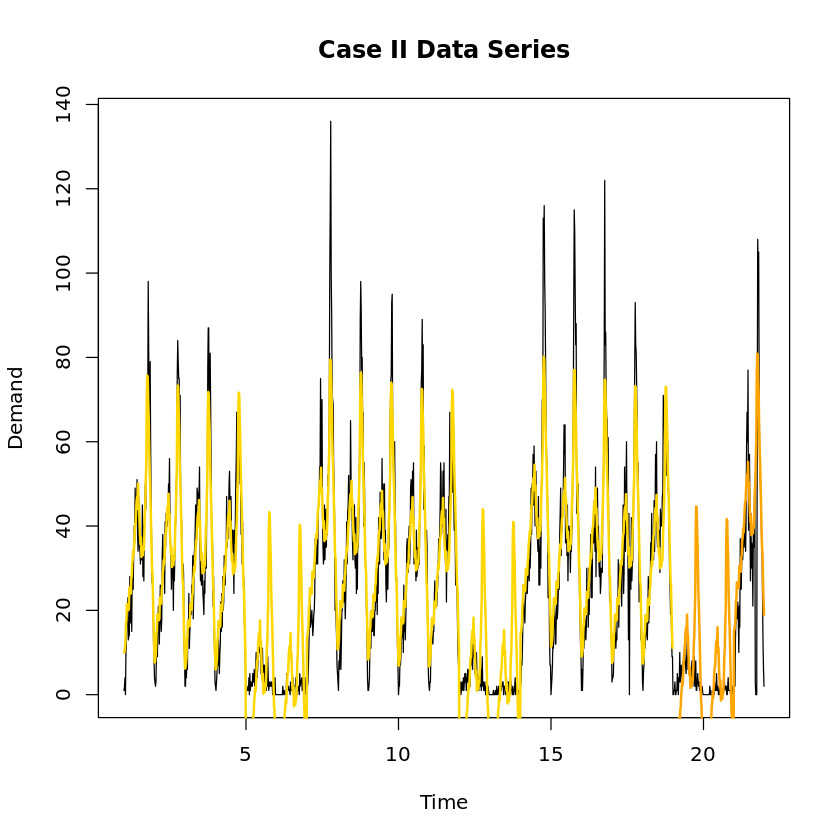

In [12]:
# Check accuracy
bicup.lm.pred <- forecast(bicup.lm, h = 63*3, level = 0, newdata = valid.df)   # Obtain prediction for validation data using model
accuracy(valid.ts, bicup.lm.pred$mean)               # Compute measures of error
plot(bicup.ts, xlab = "Time", ylab = "Demand",main="Case II Data Series")
lines(bicup.lm$fitted, lwd = 2, col = "gold")    # Plot predictions for training data in gold
lines(bicup.lm.pred$mean, lwd = 2, col = "orange")   # plot validation predictions in orange

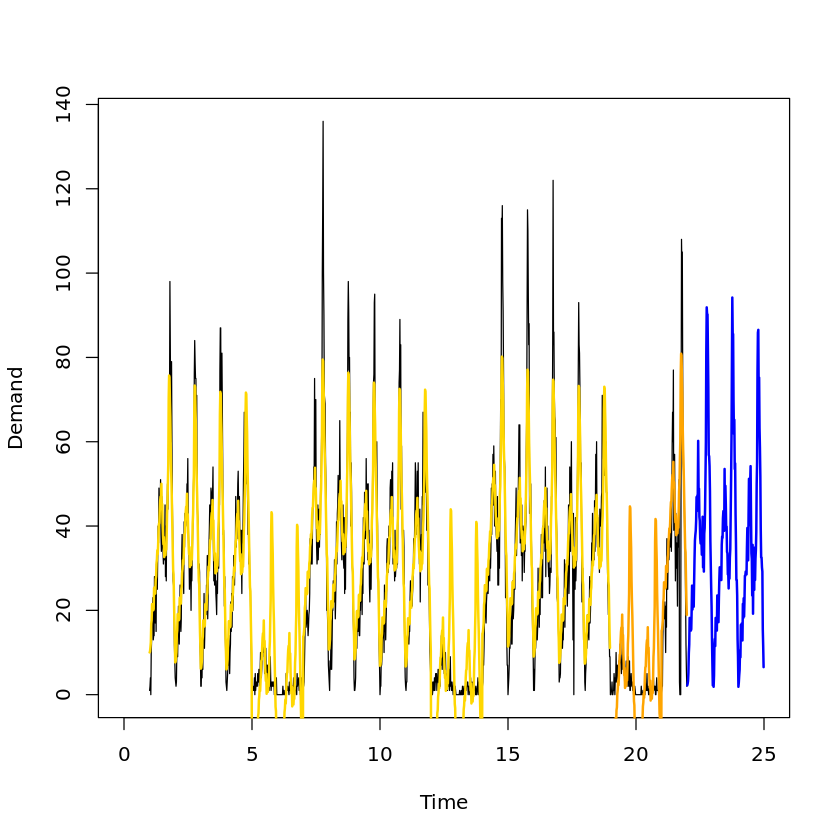

In [13]:
# Predict next 3 days
bicup.lm.fulldata <- tslm(bicup.ts ~ trend + season * day, data = bicup.df[1:(21*63),])   # Use full bicup data to build a model
bicup.lm.next3days <- forecast(bicup.lm.fulldata, h = 63*3, level = 0, newdata = next3days.df)  #Apply new odel to predict extra three days
# And plot everything (training in gold, validation in orange, extra thre days in blue)
plot(bicup.ts, xlab = "Time", ylab = "Demand", xlim = c(0, 25))
lines(bicup.lm$fitted, lwd = 2, col = "gold")
lines(bicup.lm.pred$mean, lwd = 2, col = "orange")
lines(bicup.lm.next3days$mean, lwd = 2, col = "blue")

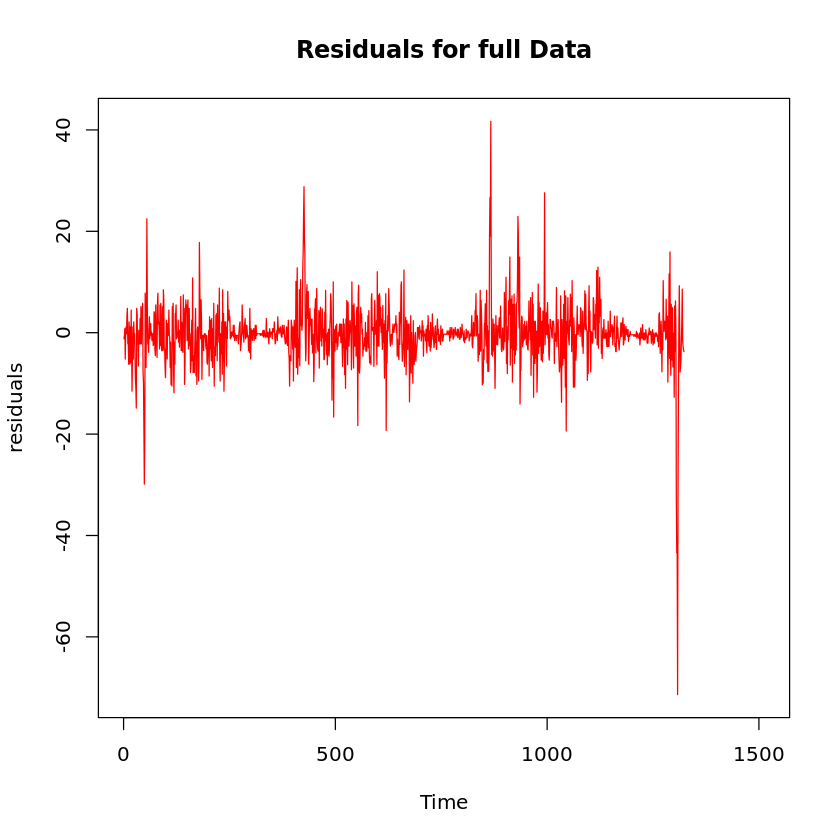

In [14]:
# Residuals 
bicup.lm.fulldata.pred <- forecast(bicup.lm.fulldata, h = 63*21, level = 0, newdata = bicup.df)
residuals <- ts(bicup.df$DEMAND-bicup.lm.fulldata.pred$mean)
plot(residuals,col="red",main="Residuals for full Data")
# Note the really nasty zag in the plot at the end of the graph! :(

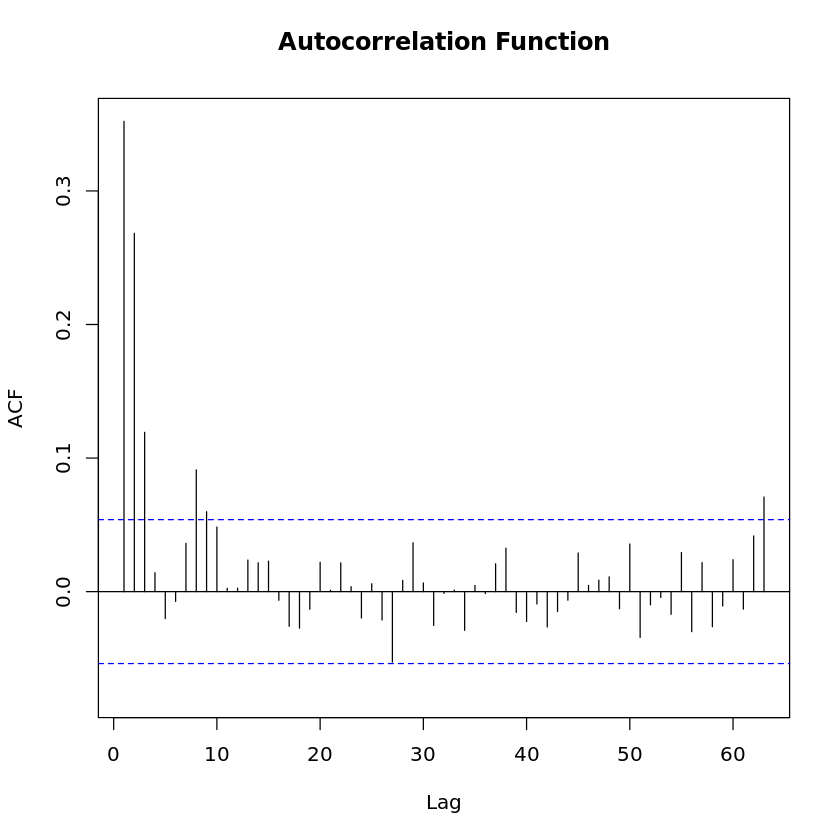

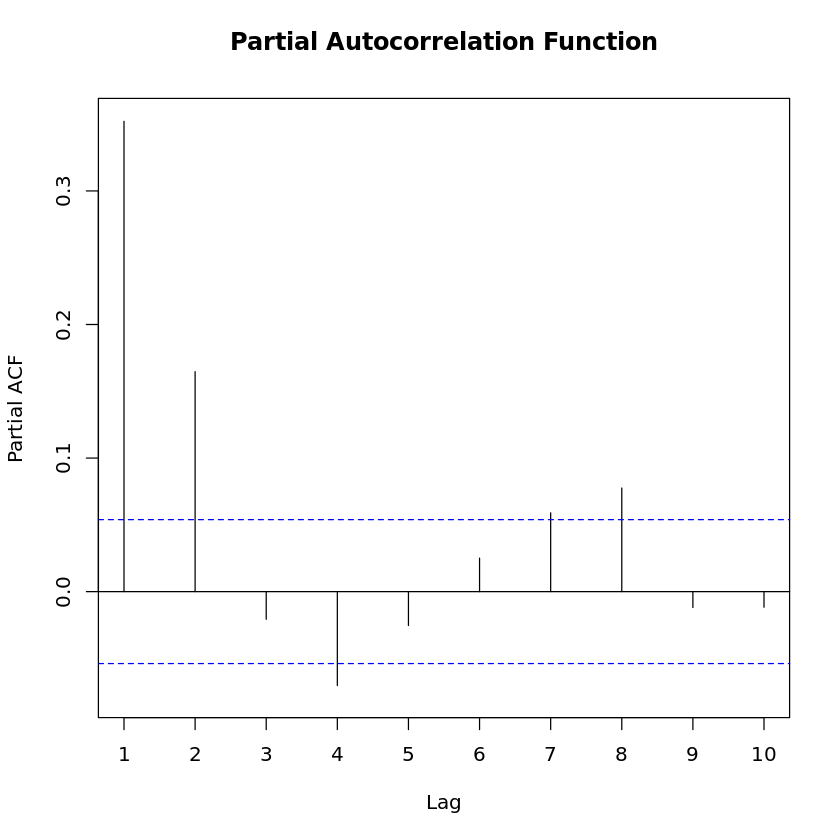

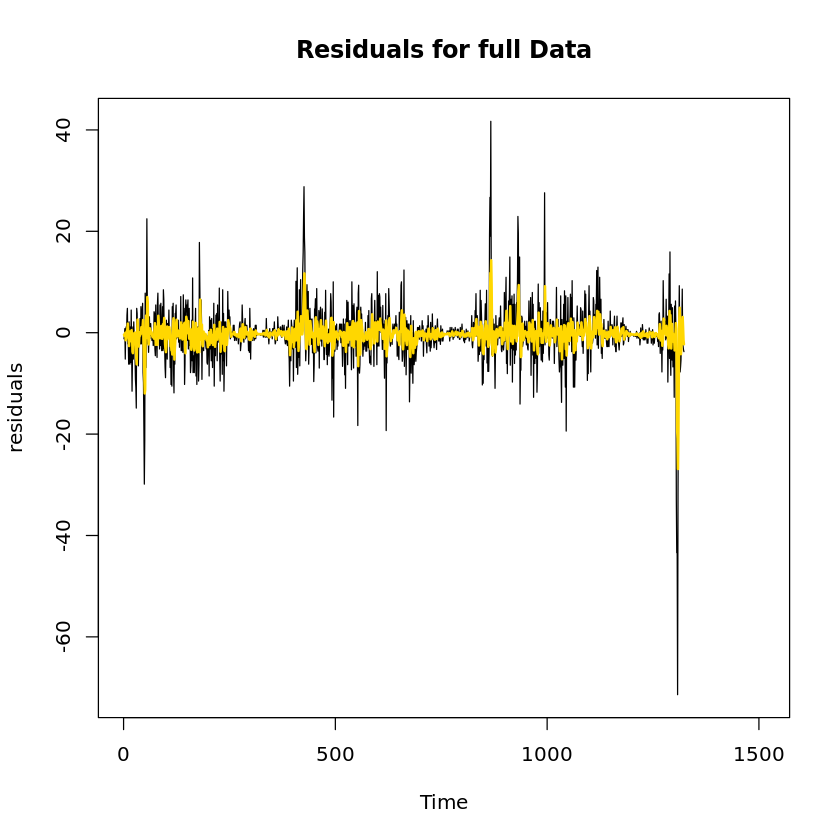

In [16]:
# Now try to add an ARIMA model to capture remaining signal in the residuals
library(tseries)
Acf(residuals,plot=TRUE,lag.max=63,main="Autocorrelation Function")
Pacf(residuals,lag.max=10,plot=TRUE,main="Partial Autocorrelation Function")
# Will try an AR(4) model. You can decide for yourself...
plot(residuals,main="Residuals for full Data")
residuals.arima.model <- Arima(residuals,order=c(4,0,0))
residuals.arima.pred <- forecast(residuals.arima.model, h = 63*21, level = 0)
lines(residuals.arima.pred$fitted,lwd = 2, col = "gold")

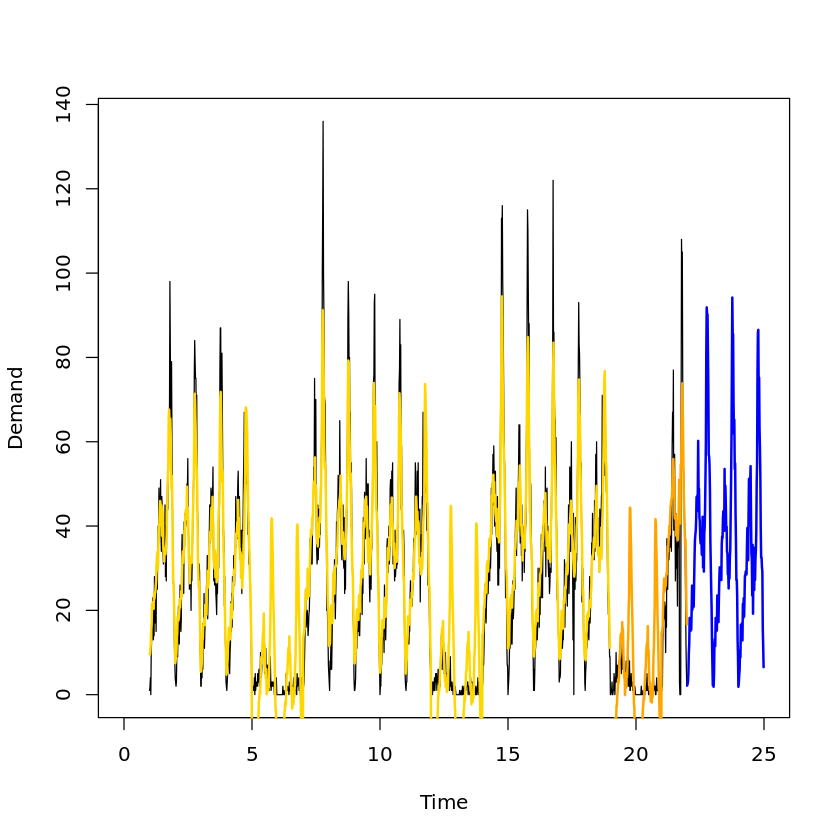

In [17]:
# Now adjust the trend and seasonal model using the ARIMA model and plot  
plot(bicup.ts, xlab = "Time", ylab = "Demand", xlim = c(0, 25))
lines(bicup.lm$fitted+residuals.arima.pred$fitted[1:(18*63)], lwd = 2, col = "gold")
lines(bicup.lm.pred$mean+residuals.arima.pred$fitted[(18*63+1):(21*63)], lwd = 2, col = "orange")
lines(bicup.lm.next3days$mean, lwd = 2, col = "blue")

In [18]:
# Finally, compute the validation performance of the ARIMA-adjusted model 
accuracy(valid.ts,bicup.lm.pred$mean+residuals.arima.pred$fitted[(18*63+1):(21*63)])

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,1.96051,15.64892,11.24645,-59.54464,238.8046,0.7875022,2.962512


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,5.170575,23.75793,19.27942,93.81749,187.783,0.9041291,1.768184


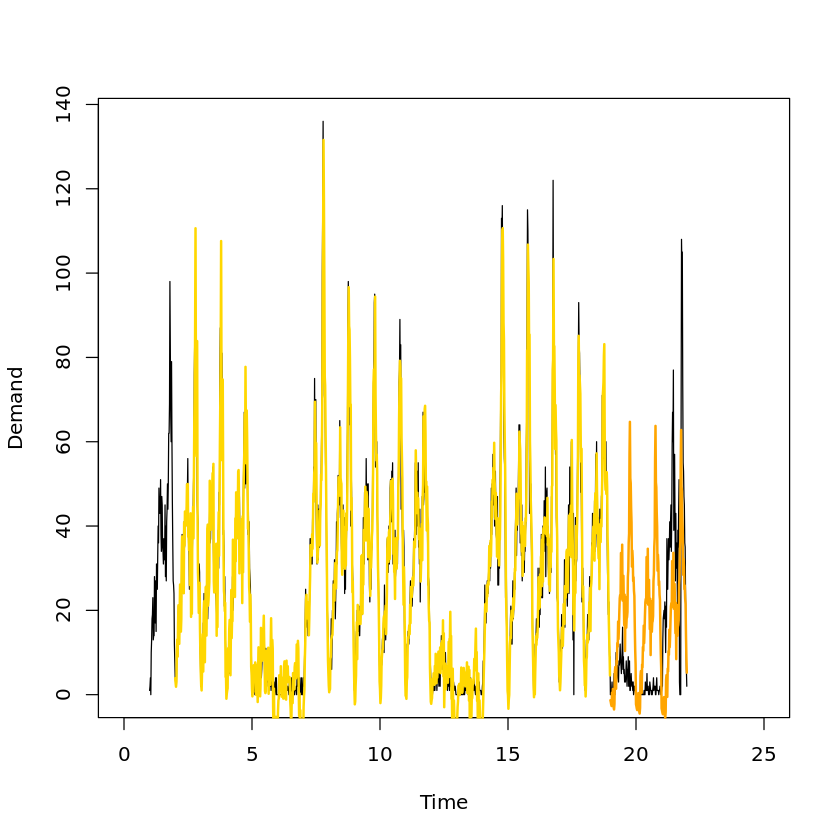

In [19]:
# MODEL 2: Exponential Smoothing (See secton 18.4 in Shmueli)
# The ets function only allows frequencies up to a maximum of 24.
# We are at 63 observations/day here, and cannot run the data with ets. Trying TTR package...
# See https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/HoltWinters
library("TTR")
bicup.hw <- HoltWinters(train.ts,seasonal="additive",optim.start = c(alpha = 0.5, beta = 0.1, gamma = 0.5))   # Build Holt Winters model 
# Check accuracy
bicup.hw.pred <- forecast(bicup.hw, h = 63*3, level = 0, newdata = valid.df)   # Obtain prediction for validation data using model
accuracy(valid.ts, bicup.hw.pred$mean)          # Compute measures of error
plot(bicup.ts, xlab = "Time", ylab = "Demand", xlim = c(0, 25))
lines(bicup.hw$fitted[,1], lwd = 2, col = "gold")
lines(bicup.hw.pred$mean, lwd = 2, col = "orange")

In [22]:
#MODEL #3 PROPHET (pronounced "profit"?)
# First get the data into Prophet format (format="%Y-%m-%d %H:%M:%S")
library(prophet)
bicup.df$DATE <- as.Date(bicup.df$DATE, format="%d-%b-%y")
prophet.df <- as.data.frame(as.POSIXct(paste(bicup.df$DATE, bicup.df$TIME)))
colnames(prophet.df)[1] <- "ds"
prophet.df$y <- bicup.df$DEMAND
train.prophet <- prophet.df[1:(18*63),]              # Again, 18 days of training data
valid.prophet <- prophet.df[(18*63+1):(21*63),]      # 3 days of validation data
next3days.prophet <- prophet.df[(21*63+1):(24*63),]  # And we'll predict three days beyond that

Loading required package: Rcpp

Loading required package: rlang



Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.



,ME,RMSE,MAE,MPE,MAPE
Test set,-4.585525,17.46576,12.83918,-1084.844,1196.107


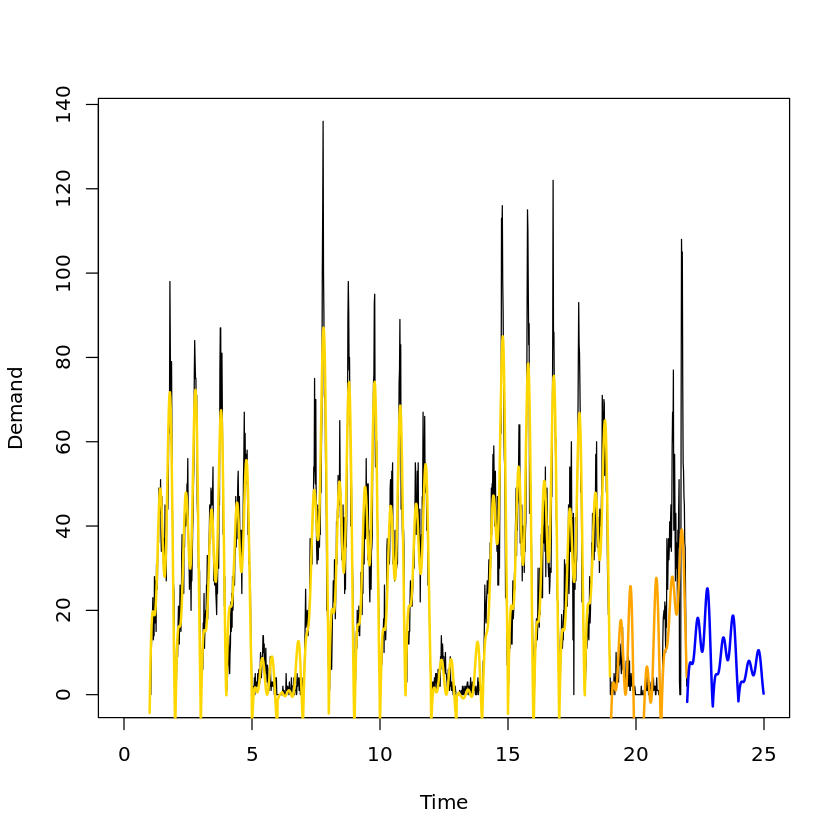

In [23]:
# The main call to prophet occurs in the next line.
# See https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274
prophet.model <- prophet(train.prophet, yearly.seasonality = "auto", weekly.seasonality = "auto",
                         daily.seasonality = "auto", holidays = NULL,
                         seasonality.mode = "multiplicative", seasonality.prior.scale = 10, changepoint.prior.scale = 0.05)
prophet.train.pred <- predict(prophet.model,train.prophet)
prophet.valid.pred <- predict(prophet.model,valid.prophet)
prophet.next3days.pred <- predict(prophet.model,next3days.prophet)
accuracy(valid.ts,prophet.valid.pred$yhat)
prophet.train.pred.ts <- ts(prophet.train.pred$yhat, start = c(1, 1), end = c(18, 63), freq = 63)
prophet.valid.pred.ts <- ts(prophet.valid.pred$yhat, start = c(19, 1), end = c(21, 63), freq = 63)
prophet.next3days.pred.ts <- ts(prophet.next3days.pred$yhat, start = c(22, 1), end = c(24, 63), freq = 63)
plot(bicup.ts, xlab = "Time", ylab = "Demand",xlim = c(0, 25))
lines(prophet.train.pred.ts, lwd = 2, col = "gold")
lines(prophet.valid.pred.ts, lwd = 2, col = "orange")
lines(prophet.next3days.pred.ts, lwd = 2, col = "blue")
# Wow, the next three days forecast looks REALLY BAD!

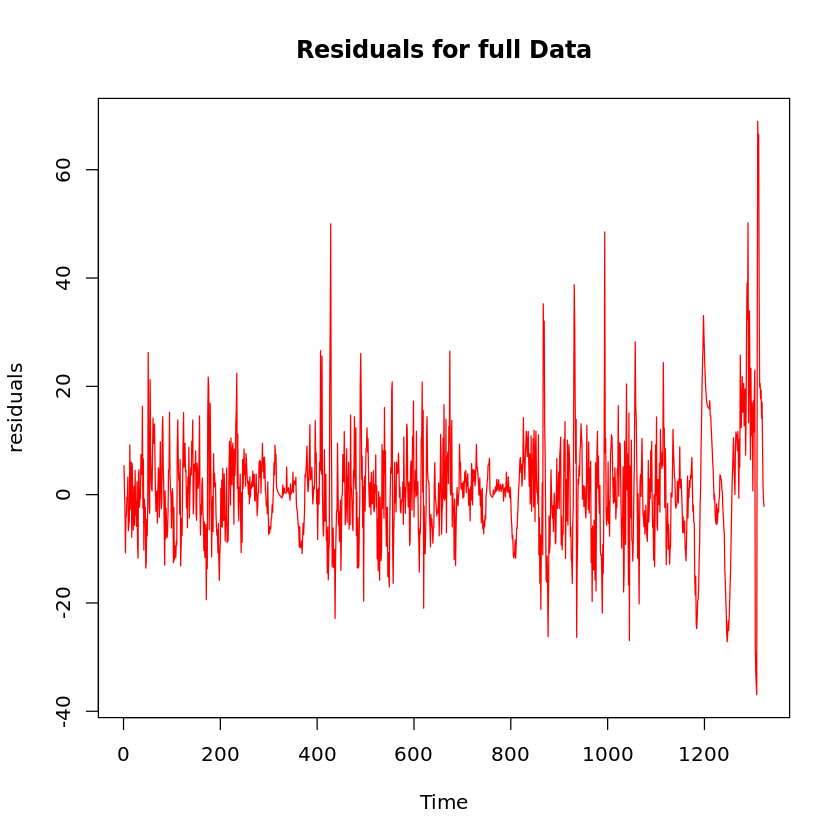

In [26]:
# Get the residuals, plot the ACF and PACF
prophet.fulldata.pred <- predict(prophet.model,prophet.df[1:(21*63),])
residuals <- ts(prophet.df$y[1:(21*63)]-prophet.fulldata.pred$yhat)
plot(residuals,col="red",main="Residuals for full Data")

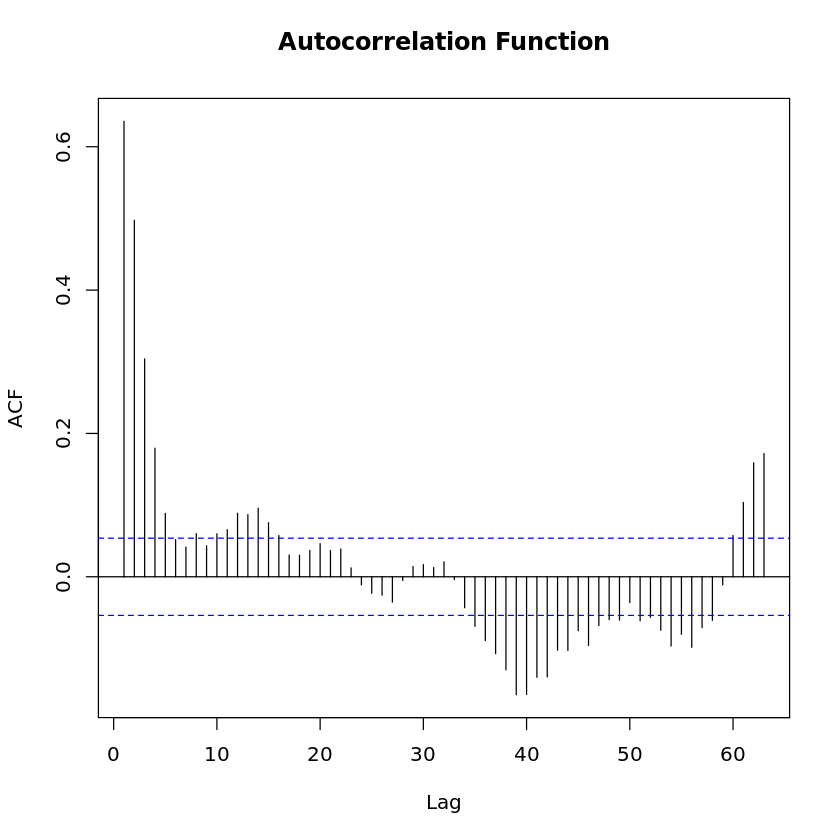

In [27]:
Acf(residuals,plot=TRUE,lag.max=63,main="Autocorrelation Function")

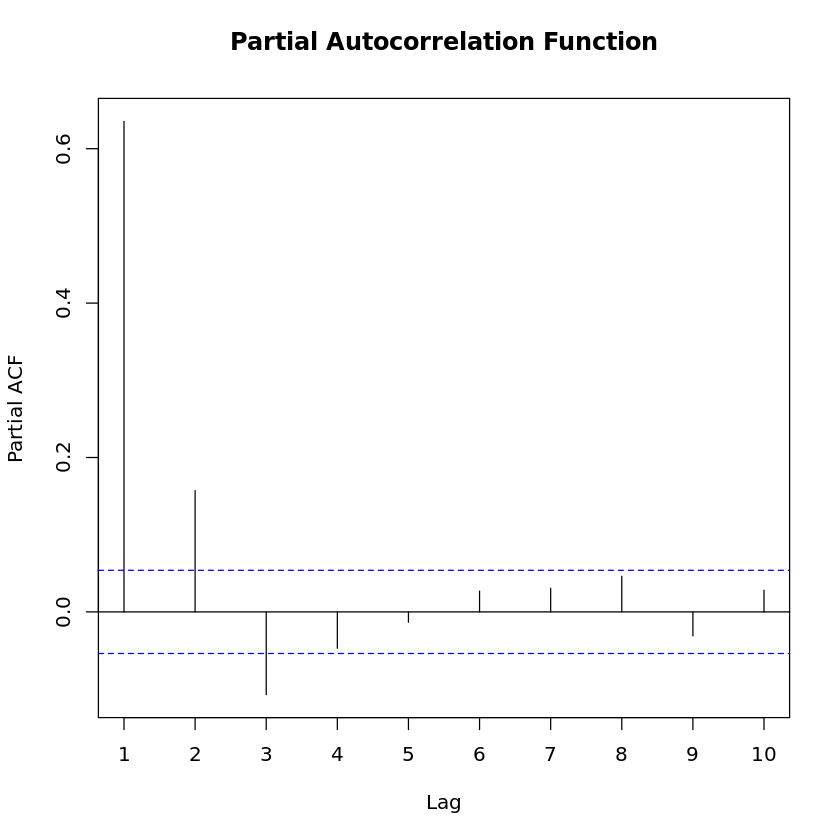

In [28]:
# THought: the ACF seems to decay, so thinking about an AR() model, and Using PACF to determine lag
Pacf(residuals,lag.max=10,plot=TRUE,main="Partial Autocorrelation Function")

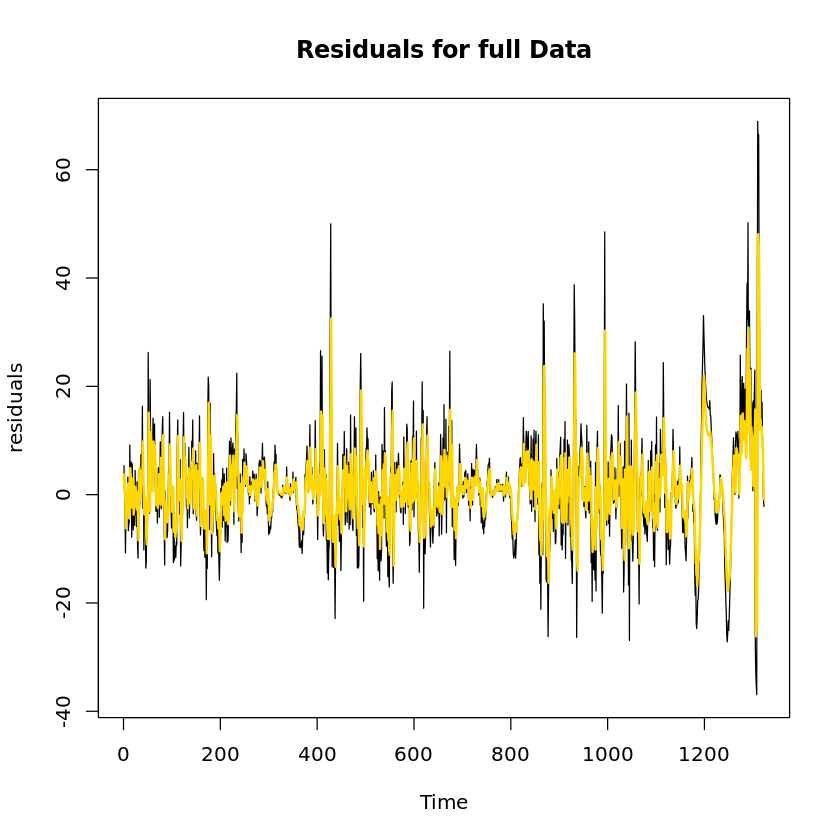

In [29]:
# Let's try an AR(3) model to capture remaning signal in the residuals
plot(residuals,main="Residuals for full Data")
prophet.arima.model <- Arima(residuals,order=c(3,0,0))
prophet.arima.pred <- forecast(prophet.arima.model, h = 63*21, level = 0)
lines(prophet.arima.pred$fitted,lwd = 2, col = "gold")

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.700743,8.026008,7.700743,94.70384,94.70384,-0.5973826,2.412284


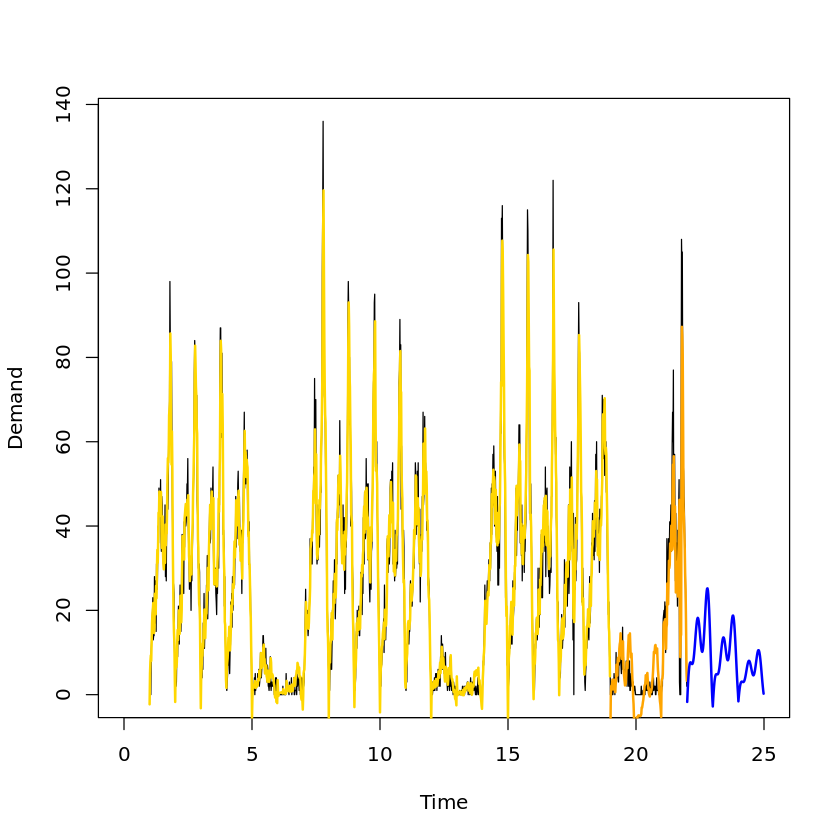

In [30]:
# Accuracy of ARIMA-adjusted model and Plot
accuracy(valid.ts,prophet.valid.pred$yhat+prophet.arima.pred$fitted)
plot(bicup.ts, xlab = "Time", ylab = "Demand",xlim = c(0, 25))
lines(prophet.train.pred.ts+prophet.arima.pred$fitted[1:(18*63)], lwd = 2, col = "gold")
lines(prophet.valid.pred.ts+prophet.arima.pred$fitted[(18*63+1):(21*63)], lwd = 2, col = "orange")
lines(prophet.next3days.pred.ts, lwd = 2, col = "blue")
# Best RMSE, but it knows NOTHING about days 22-24!